In [7]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from transformers import (GPT2Tokenizer, GPT2Model, 
                          set_seed,
                          training_args,
                          trainer,
                          GPT2Config,
                          get_cosine_schedule_with_warmup,
                          GPT2ForSequenceClassification)

set_seed(123)
epochs=4
batch_size = 32

# Numero massimo della sequenza
# La sequenza <60 avrà del padding, la sequenza >60 sarà tronacata
max_length = 60

# Usiamo la cpu se la gpu non viene trova
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Nome del trasformers model pre-allenato
model_name_or_path = 'gpt2'

# Dizionario delle etichette e il loro ID
labels_ids = {'BIT': 0, 'BPMAI': 1, 'Camunda':2, 'eCH':3}

# Numero di etichette che stiamo utilizzando
n_labels = len(labels_ids)

In [8]:
import os
import pandas as pd
import torch
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

%run "./support_functions.ipynb"


#Creazione di un Dataset pytorch per il caricamento dei dati
class BPMNDomainDataset(Dataset):
    
    def __init__(self, path):

        # Prima di tutto controlliamo che il path esista
        if not os.path.isfile(path):
            # Se il path non è valido allora solleviamo un'eccezione
            raise ValueError('Invalid `path` variable! Needs to be a file')
        
        # Carico il file .csv
        self.df = pd.read_csv(path, sep=';', engine='python', encoding=get_file_encoding(path))

        # Estraggo le etichette e i dominii di appartenenza
        self.descriptions = self.df['Labels'].to_list()
        self.domains = self.df['CollectionName'].to_list()

        # Flatten the list of labels
        self.flattened_domains = [label for sublist in self.domains for label in eval(sublist)]

        # Ottengo il numero di righe
        self.n_examples = len(self.descriptions)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
        return {'text': self.descriptions[item], 'label': self.flattened_domains[item]}

#Prepara i dati in modo che possano essere utilizzati efficacemente 
#durante l'addestramento di un modello GPT-2 per la classificazione di sequenze.
class Gpt2ClassificationCollator(object):
    """
    Usa un tokenizzatore e un'encoder di etichette per convertire il testo e le etichette in
    numeri che possono essere usati in un modello GPT-2.
    
    Argomenti:

      use_tokenizer:
          I trasformatori tokenizer processano testo grezzo in numeri.
          
      labels_ids:
          Dizionatio che codifica ogni nome di un'etichetta in numeri.Le chiavi vengono 
          mappate ai nomi delle etichette e i valori vengono mappati ai numeri associati a tali etichette.

      max_sequence_len:
           Valore usato per indicare la sequenza massima per troncare o per riempire il testo. 
           Se non viene passato alcun valore, verrà utilizzata la dimensione massima della sequenza
           supportato dal tokenizzatore e dal modello.
           
      labels_encoder:
           Un dizionario che mappa le etichette delle sequenze ai loro rispettivi codici numerici.

    """
    def __init__(self, 
                 use_tokenizer, 
                 labels_encoder, 
                 max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder
        
        """
        Ciò che rende l'oggetto istanza della classe un "collator". 
        Questo metodo è ciò che viene chiamato quando l'oggetto Gpt2ClassificationCollator viene 
        chiamato direttamente, come se fosse una funzione.
        
        Argomenti:
        
            sequences:
                dove ogni sequence è un dizionario con due chiavi: 'text' e 'label'. 
                'text' contiene il testo della sequenza, mentre 'label' contiene l'etichetta associata alla sequenza.
        """
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        domains = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in domains]#per ogni etichetta in dominio, mi cerco la codifica e la salvo
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)#per ogni descrizione in texts, mi calcolo i token e li salvo
        inputs.update({'labels': torch.tensor(labels)})
        return inputs

def train(model, dataloader, optimizer, scheduler, device):
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.train()
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss


def validation(dataloader, device_, model):
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.eval()
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            predictions_labels += predict_content
    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss

In [3]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cpu`


In [9]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, labels_encoder=labels_ids, max_sequence_len=max_length)

print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = BPMNDomainDataset(path='./BPMNtraining.csv')
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset = BPMNDomainDataset(path='./BPMNtesting.csv')
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 8716 examples!
Created `train_dataloader` with 273 batches!
Dealing with Validation...
Created `valid_dataset` with 3735 examples!
Created `eval_dataloader` with 117 batches!


Epoch


  0%|                                                                | 0/4 [00:00<?, ?it/s]


Training on batches...



 31%|████████████████▌                                    | 85/273 [02:45<06:00,  1.92s/it]


 63%|████████████████████████████████▌                   | 171/273 [05:33<03:14,  1.91s/it]


 94%|████████████████████████████████████████████████▉   | 257/273 [08:19<00:30,  1.92s/it]


100%|████████████████████████████████████████████████████| 273/273 [08:49<00:00,  1.94s/it]


Validation on batches...



 73%|██████████████████████████████████████▌              | 85/117 [00:45<00:17,  1.83it/s]


 25%|█████████████▊                                         | 1/4 [09:51<29:35, 591.95s/it]

  train_loss: 0.04052 - val_loss: 0.05342 - train_acc: 0.99094 - valid_acc: 0.98902

Training on batches...



 31%|████████████████▌                                    | 85/273 [02:49<06:14,  1.99s/it]


 63%|████████████████████████████████▌                   | 171/273 [05:37<03:20,  1.97s/it]


 94%|████████████████████████████████████████████████▉   | 257/273 [08:25<00:31,  1.94s/it]


100%|████████████████████████████████████████████████████| 273/273 [08:56<00:00,  1.96s/it]


Validation on batches...



 73%|██████████████████████████████████████▌              | 85/117 [00:45<00:16,  1.90it/s]


 50%|███████████████████████████▌                           | 2/4 [19:50<19:51, 595.74s/it]

  train_loss: 0.02380 - val_loss: 0.04253 - train_acc: 0.99403 - valid_acc: 0.99224

Training on batches...



 31%|████████████████▌                                    | 85/273 [02:53<06:38,  2.12s/it]


 63%|████████████████████████████████▌                   | 171/273 [05:48<03:26,  2.02s/it]


 94%|██████████████████████████████████████████████▏  | 257/273 [1:16:55<55:33, 208.33s/it]


100%|██████████████████████████████████████████████████| 273/273 [1:17:25<00:00, 17.02s/it]


Validation on batches...



 73%|██████████████████████████████████████▌              | 85/117 [00:52<00:18,  1.75it/s]


 75%|███████████████████████████████████████             | 3/4 [1:38:28<41:17, 2477.94s/it]

  train_loss: 0.01427 - val_loss: 0.01975 - train_acc: 0.99644 - valid_acc: 0.99652

Training on batches...



 31%|████████████████▌                                    | 85/273 [02:48<05:55,  1.89s/it]


 63%|████████████████████████████████▌                   | 171/273 [05:36<03:27,  2.04s/it]


 94%|████████████████████████████████████████████████▉   | 257/273 [08:23<00:30,  1.93s/it]


100%|████████████████████████████████████████████████████| 273/273 [08:53<00:00,  1.95s/it]


Validation on batches...



 73%|██████████████████████████████████████▌              | 85/117 [00:45<00:16,  1.92it/s]


100%|████████████████████████████████████████████████████| 4/4 [1:48:23<00:00, 1625.90s/it]

  train_loss: 0.00858 - val_loss: 0.02023 - train_acc: 0.99771 - valid_acc: 0.99652


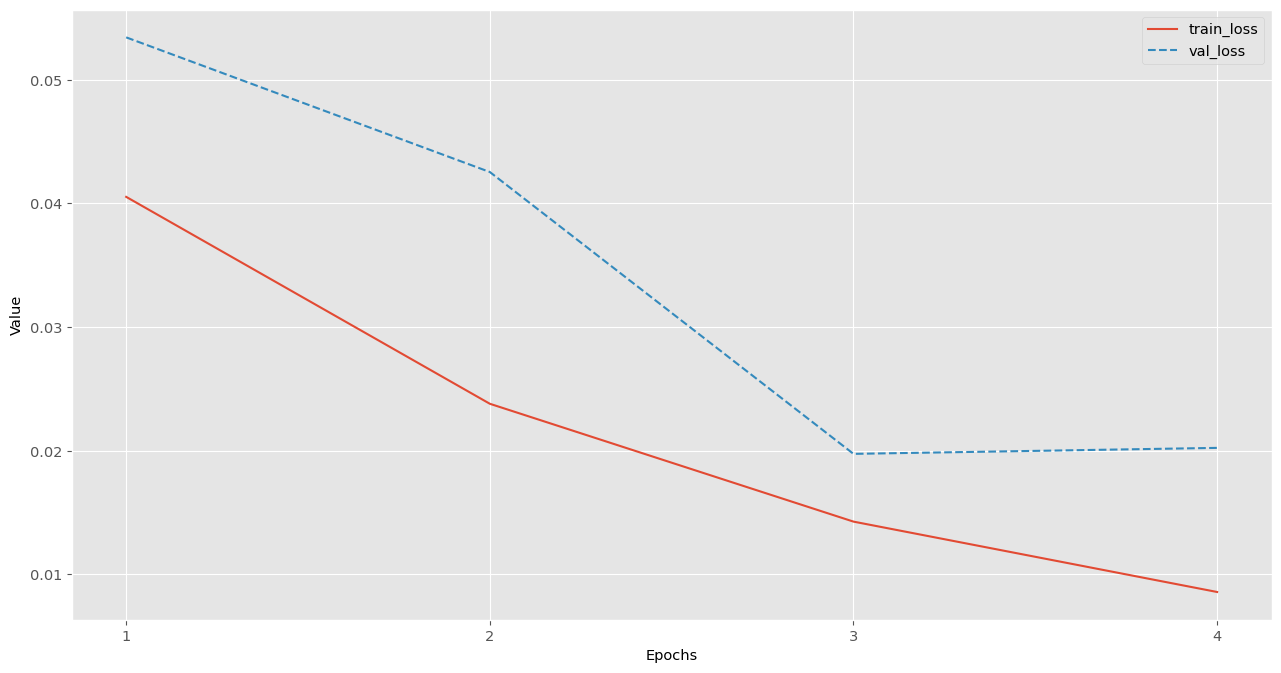

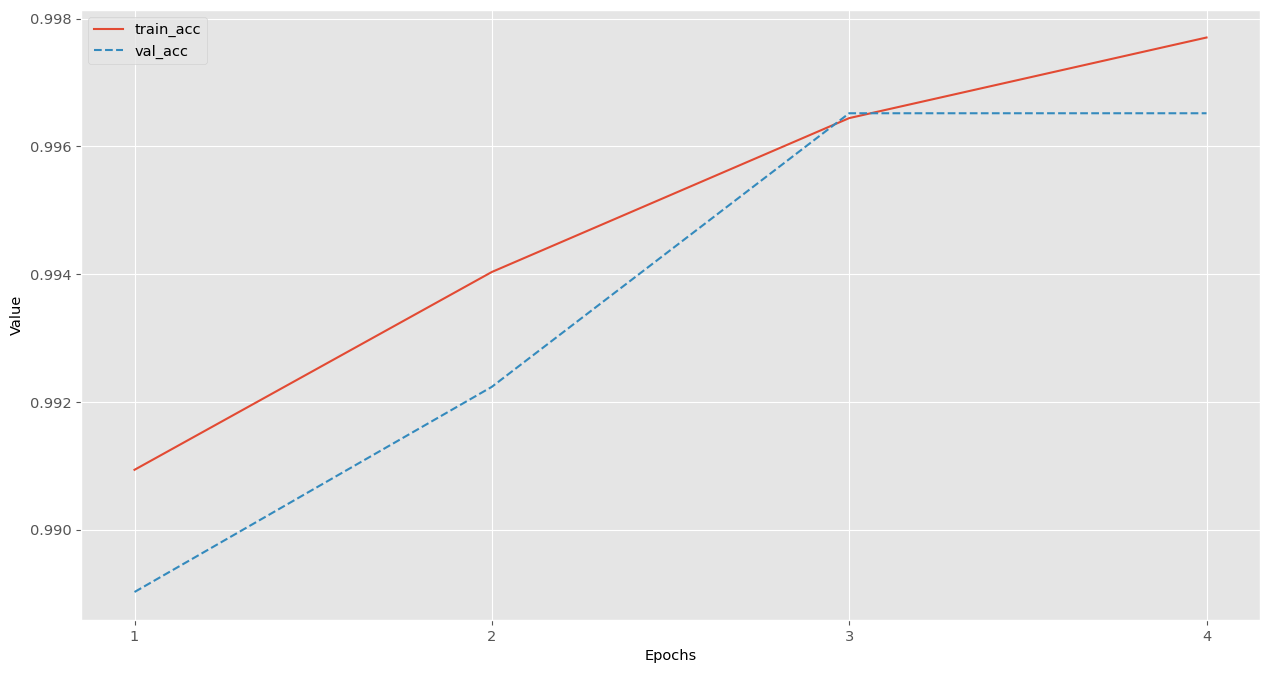

In [10]:
from torch.optim import AdamW
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8)
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,  # Default value in run_glue.py
                                            num_training_steps=total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(model, train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data. 
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device, model)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f" % (train_loss, val_loss, train_acc, val_acc))

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'], magnify=0.1)

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'], magnify=0.1)


In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device, model)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, 
                                           labels=list(labels_ids.values()), 
                                           target_names=list(labels_ids.keys()), 
                                           zero_division=1)  # Impostato su 1 per impostare precision e F-score a 0 quando non ci sono campioni predetti

# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

 99%|███████████████████████████████████████████████████▌| 116/117 [01:05<00:00,  1.77it/s]